In [1]:
import pandas as pd

df = pd.read_csv("sample_questions.csv")

In [2]:
df_dct = df.to_dict(orient="records")

In [13]:
from sentence_transformers import SentenceTransformer
from qdrant_client import QdrantClient
from qdrant_client.models import Distance, VectorParams, PointStruct
from langchain.text_splitter import RecursiveCharacterTextSplitter
from typing import Any
import uuid


class QdrantConnector:
      
    def __init__(
        self, 
        qdrant_host: str = "localhost", 
        qdrant_port: int = 6333,
        embedding_model: str = "jinaai/jina-embeddings-v2-small-en",
        collection_name: str = "pdf_documents_jinaai"
    ):
        self.qdrant_client = QdrantClient(host=qdrant_host, port=qdrant_port)
        self.embedding_model = SentenceTransformer(embedding_model)
        self.collection_name = collection_name
        self._ensure_collection_exists()

    @property
    def sentence_splitter(self):
        return RecursiveCharacterTextSplitter(
            chunk_size=500,     # Number of characters per chunk
            chunk_overlap=50,   # Overlap to maintain context
            separators=["\n\n", "\n", ".", " "]  # Prioritize splitting on paragraph, newline, and sentence boundaries
        )
    
    def _ensure_collection_exists(self):
        """Check and create collection in Qdrant if it doesn't exist"""
        try:
            collections = self.qdrant_client.get_collections()
            collection_names = [col.name for col in collections.collections]
            
            if self.collection_name not in collection_names:
                # Create collection with appropriate parameters
                vector_size = self.embedding_model.get_sentence_embedding_dimension()
                print(f"Creating collection '{self.collection_name}' with vector size {vector_size}")
                
                self.qdrant_client.create_collection(
                    collection_name=self.collection_name,
                    vectors_config=VectorParams(
                        size=vector_size,
                        distance=Distance.COSINE
                    )
                )
                print(f"Created collection '{self.collection_name}'")
            else:
                print(f"Collection '{self.collection_name}' already exists")
        except Exception as e:
            print(f"Error creating collection: {e}")

    def upload_to_qdrant(
        self, 
        text: str,
        metadata: dict[str, Any] = None
    ) -> None:
        """
        Upload chunks and embeddings to Qdrant
        
        Args:
            chunks: List of text chunks
            embeddings: Embeddings for chunks
            metadata: Additional metadata (e.g., filename, page)
        
        Returns:
            List of IDs of added points
        """
        sentence_chunks = self.sentence_splitter.split_text(text)
        print(f"text spliited into {len(sentence_chunks)} chunks")
        for i, chunk in enumerate(sentence_chunks):
            point_id = str(uuid.uuid4())
            embedding = self.embedding_model.encode(chunk)

            payload = {
                "text": chunk,
                "chunk_index": i,
                "chunk_length": len(chunk)
            }
            if metadata:
                payload.update(metadata)

            point = PointStruct(
                id=point_id,
                vector=embedding.tolist(),
                payload=payload
            )
            try:
                self.qdrant_client.upsert(
                    collection_name=self.collection_name,
                    points=[point]
                )
                print(f"Uploaded point {point_id} to Qdrant")
            except Exception as e:
                print(f"Error uploading to Qdrant: {e}")
                return None

    def search_similar(self, query: str, limit: int = 5) -> list[dict]:
            """
            Search for similar chunks to query
            
            Args:
                query: Text query
                limit: Maximum number of results
            
            Returns:
                List of similar chunks with metadata
            """
            # Create embedding for query
            query_embedding = self.embedding_model.encode([query])[0]
            
            # Search in Qdrant
            search_results = self.qdrant_client.search(
                collection_name=self.collection_name,
                query_vector=query_embedding.tolist(),
                limit=limit
            )
            
            results = []
            for result in search_results:
                results.append({
                    "text": result.payload["text"],
                    "score": result.score,
                    "file_name": result.payload.get("file_name", "unknown"),
                    "chunk_index": result.payload.get("chunk_index", 0)
                })
            
            return results


In [107]:
def build_prompt(query, search_results):
    prompt_template = """
        nothink/
        You're a pdf research assistant. Answer the QUESTION based on the CONTEXT from the Qdrant database.
        Use only the facts from the CONTEXT when answering the QUESTION.

        QUESTION: {question}

        CONTEXT: {context}
    """.strip()

    prompt = prompt_template.format(question=query, context=search_results).strip()
    return prompt

In [93]:
qdrant_connector = QdrantConnector(
    embedding_model = "jinaai/jina-embeddings-v2-small-en",
    collection_name = "pdf_documents_jinaai"
)

Some weights of BertModel were not initialized from the model checkpoint at jinaai/jina-embeddings-v2-small-en and are newly initialized: ['embeddings.position_embeddings.weight', 'encoder.layer.0.intermediate.dense.bias', 'encoder.layer.0.intermediate.dense.weight', 'encoder.layer.0.output.LayerNorm.bias', 'encoder.layer.0.output.LayerNorm.weight', 'encoder.layer.0.output.dense.bias', 'encoder.layer.0.output.dense.weight', 'encoder.layer.1.intermediate.dense.bias', 'encoder.layer.1.intermediate.dense.weight', 'encoder.layer.1.output.LayerNorm.bias', 'encoder.layer.1.output.LayerNorm.weight', 'encoder.layer.1.output.dense.bias', 'encoder.layer.1.output.dense.weight', 'encoder.layer.2.intermediate.dense.bias', 'encoder.layer.2.intermediate.dense.weight', 'encoder.layer.2.output.LayerNorm.bias', 'encoder.layer.2.output.LayerNorm.weight', 'encoder.layer.2.output.dense.bias', 'encoder.layer.2.output.dense.weight', 'encoder.layer.3.intermediate.dense.bias', 'encoder.layer.3.intermediate.den

Collection 'pdf_documents_jinaai' already exists


In [108]:
import ollama
from ollama import GenerateResponse

def rag(query: str, model: str) -> GenerateResponse:
    print("Searching in qdrant db")
    search_result = qdrant_connector.search_similar(query=query)
    ollama_host = "http://localhost:11434"
    client = ollama.Client(host=ollama_host)
    prompt = build_prompt(query, search_result)
    print(prompt)
    response = client.generate(
        model=model,
        prompt=prompt
        
    )
    return response


In [109]:
asnwers = []

In [110]:
for question in df_dct:
    model = "qwen3:latest"
    query = question["question"]
    response = rag(query, model)
    answer = response.response.replace("<think>\n", "").replace("</think>\n", "")
    print(answer)
    asnwers.append(
        {
            "question": query,
            "answer": answer,
            "model": model
        }
    )

Searching in qdrant db
nothink/
        You're a pdf research assistant. Answer the QUESTION based on the CONTEXT from the Qdrant database.
        Use only the facts from the CONTEXT when answering the QUESTION.

        QUESTION: Jaka jest nazwa kierunku studiów opisanych w programie?

        CONTEXT: [{'text': 'występuje ze stosownym podaniem do opiekuna praktyk na kierunku zarządzanie i inżynieria produkcji  w \nterminie najpóźniej na 14 dni przed końcem zajęć dydaktycznych semestru, w programie którego jest \nprzewidziana praktyka. Jeżeli prom otor uzna, że uzyskane przez studenta doświadczenie zawodowe nie \njest wystarczające np. do realizacji pracy dyplomowej, to wówczas student zobowiązany jest do odbycia \npraktyki.', 'score': 0.5866106, 'file_name': '4_Program_studiow_zarządzanie i inżynieria produkcji_WIM_I_stacj_niest_og.pdf', 'chunk_index': 54}, {'text': 'podczas zajęć laboratoryjnych, projektowych, a także w trakcie realizacji pracy dyplomowej. Podczas \nzajęć laborator

/var/folders/k2/8_xbq0kj3yq1ydl1c3mcpp580000gn/T/ipykernel_92392/3413632836.py:115: DeprecationWarning: `search` method is deprecated and will be removed in the future. Use `query_points` instead.
  search_results = self.qdrant_client.search(




Nazwa kierunku studiów opisanych w programie to "zarządzanie i inżynieria produkcji".
Searching in qdrant db
nothink/
        You're a pdf research assistant. Answer the QUESTION based on the CONTEXT from the Qdrant database.
        Use only the facts from the CONTEXT when answering the QUESTION.

        QUESTION: Na jakim poziomie Polskiej Ramy Kwalifikacji znajduje się ten kierunek?

        CONTEXT: [{'text': 'ds. jakości kształcenia lub dziekana.  \nWydział Inżynierii Mechanicznej za jeden z najważniejszych elementów kształtowania programu \nkształcenia uznaje współpracę z pracodawcami. Ma ona charakter sformalizowany i niesformalizowany, \nnp. dyskusje z przedstawicielami przemysłu podczas różnego typu s potkań, konferencji i uroczystości \nWydziałowych z bardzo licznym udziałem przedstawicieli przemysłu. Do interesariuszy zewnętrznych', 'score': 0.598796, 'file_name': '4_Program_studiow_zarządzanie i inżynieria produkcji_WIM_I_stacj_niest_og.pdf', 'chunk_index': 121}, {'text'

In [111]:
prompt2_template = """
/nothink/
You are an expert evaluator for a RAG system.
Your task is to analyze the relevance of the generated answer to the given question.
Based on the relevance of the generated answer, you will classify it
as "NON_RELEVANT", "PARTLY_RELEVANT", or "RELEVANT".

Here is the data for evaluation:

Question: {question}
Generated Answer: {answer_llm}

Please analyze the content and context of the generated answer in relation to the question
and provide your evaluation in parsable JSON without using code blocks:

{{
  "Relevance": "NON_RELEVANT" | "PARTLY_RELEVANT" | "RELEVANT",
  "Explanation": "[Provide a brief explanation for your evaluation]"
}}
""".strip()

In [112]:
relevance = []

In [113]:
for i, element in enumerate(asnwers):
    question = element["question"]
    answer_llm = element["answer"]
    model = element["model"]
    prompt2 = prompt2_template.format(question=question, answer_llm=answer_llm)
    response = ollama.generate(
        model=model,
        prompt=prompt2
    )
    print(f"Evaluating question: {question}, index: {i}, model: {model}")
    relevance.append(response)

Evaluating question: Jaka jest nazwa kierunku studiów opisanych w programie?, index: 0, model: qwen3:latest
Evaluating question: Na jakim poziomie Polskiej Ramy Kwalifikacji znajduje się ten kierunek?, index: 1, model: qwen3:latest
Evaluating question: Ile semestrów trwają studia stacjonarne na kierunku zarządzanie i inżynieria produkcji?, index: 2, model: qwen3:latest
Evaluating question: Jaki tytuł zawodowy otrzymuje absolwent tego kierunku?, index: 3, model: qwen3:latest
Evaluating question: Ile punktów ECTS trzeba zdobyć, aby ukończyć studia stacjonarne?, index: 4, model: qwen3:latest
Evaluating question: Ile godzin zajęć obejmuje program studiów stacjonarnych?, index: 5, model: qwen3:latest
Evaluating question: Ile godzin praktyk przewidziano w programie dla studiów stacjonarnych?, index: 6, model: qwen3:latest
Evaluating question: W jakim języku prowadzone są zajęcia?, index: 7, model: qwen3:latest
Evaluating question: Jakie są kluczowe efekty uczenia się w zakresie wiedzy?, inde

In [114]:
relevance

[GenerateResponse(model='qwen3:latest', created_at='2025-08-21T12:58:47.312266Z', done=True, done_reason='stop', total_duration=6950505250, load_duration=66351000, prompt_eval_count=204, prompt_eval_duration=1818561250, eval_count=67, eval_duration=5065132583, response='<think>\n\n</think>\n\n{\n  "Relevance": "RELEVANT",\n  "Explanation": "The generated answer directly addresses the question by providing the name of the study program direction, which is \'zarządzanie i inżynieria produkcji\'. The answer is concise and fully relevant to the query."\n}', thinking=None, context=[151644, 872, 198, 33100, 26865, 5894, 2610, 525, 458, 6203, 69810, 369, 264, 431, 1890, 1849, 624, 7771, 3383, 374, 311, 23643, 279, 40861, 315, 279, 7907, 4226, 311, 279, 2661, 3405, 624, 28715, 389, 279, 40861, 315, 279, 7907, 4226, 11, 498, 686, 48129, 432, 198, 300, 330, 29563, 2192, 85411, 2821, 497, 330, 33490, 8932, 2192, 85411, 2821, 497, 476, 330, 787, 85411, 2821, 11436, 8420, 374, 279, 821, 369, 16460,

In [115]:
import json
responses = [json.loads(answer.response.replace("<think>\n","").replace("</think>\n","").strip()) for answer in relevance]

In [116]:
asnwers

[{'question': 'Jaka jest nazwa kierunku studiów opisanych w programie?',
  'answer': '\n\nNazwa kierunku studiów opisanych w programie to "zarządzanie i inżynieria produkcji".',
  'model': 'qwen3:latest'},
 {'question': 'Na jakim poziomie Polskiej Ramy Kwalifikacji znajduje się ten kierunek?',
  'answer': '\n\nNa podstawie kontekstu, kierunek "zarządzanie i inżynieria produkcji" znajduje się na poziomie 6 Polskiej Ramy Kwalifikacji (PRK).',
  'model': 'qwen3:latest'},
 {'question': 'Ile semestrów trwają studia stacjonarne na kierunku zarządzanie i inżynieria produkcji?',
  'answer': '\n\nNa podstawie dostarczonych informacji nie można jednoznacznie określić, ile semestrów trwają studia stacjonarne na kierunku zarządzanie i inżynieria produkcji. Żaden z fragmentów kontekstu nie zawiera jasnej odpowiedzi na to pytanie.',
  'model': 'qwen3:latest'},
 {'question': 'Jaki tytuł zawodowy otrzymuje absolwent tego kierunku?',
  'answer': '\n\nNa podstawie dostarczonego kontekstu nie można jedno

In [117]:
result = [{**elem, **asnwers[responses.index(elem)]} for elem in responses]

In [118]:
df = pd.DataFrame(result)
df.to_csv("rag_evaluation_results.csv", index=False)

<Axes: title={'center': 'RAG Evaluation Relevance Distribution'}, xlabel='Relevance'>

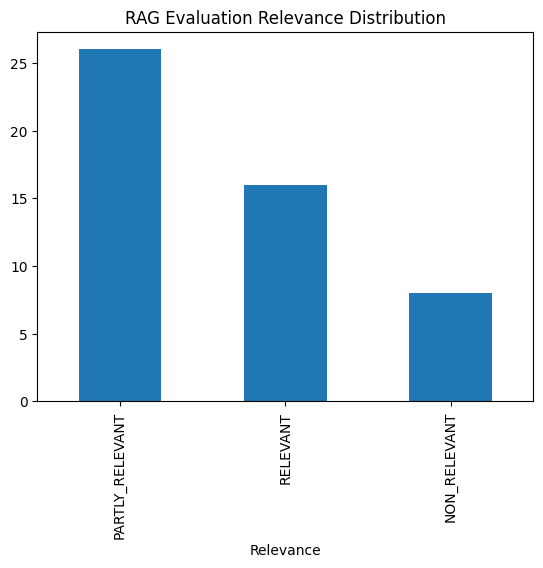

In [119]:
df["Relevance"].value_counts().plot(kind="bar", title="RAG Evaluation Relevance Distribution")